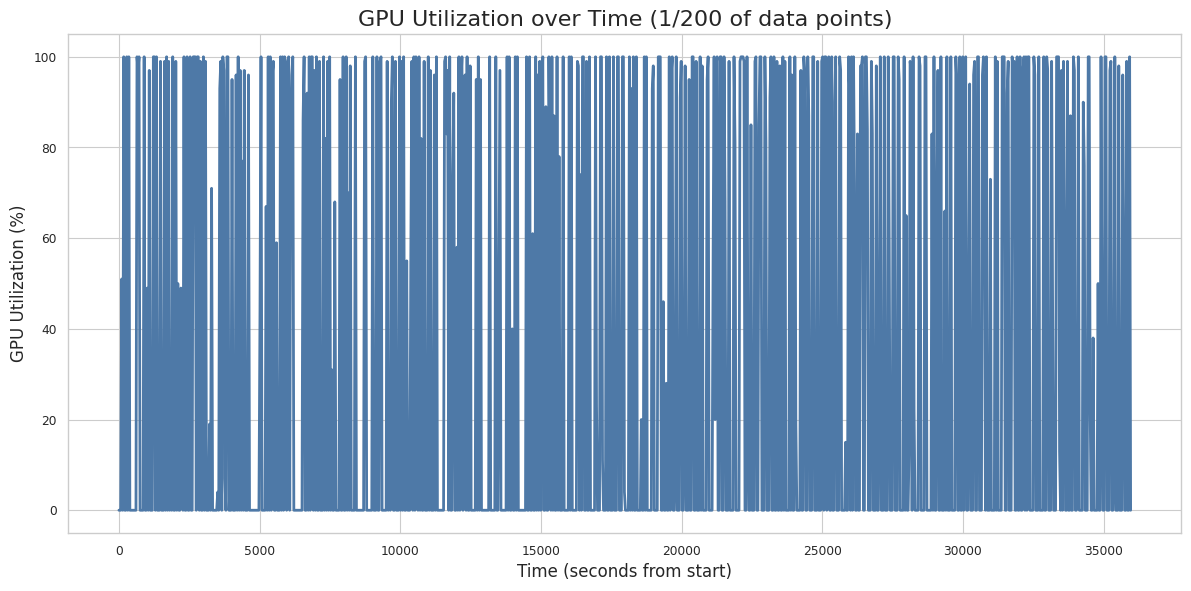

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta


def plot_downsampled(csv_path, downsample_factor):
    # load the data
    df = pd.read_csv(csv_path)
    
    # convert timestamp to datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
    
    # normalize time to start at 0
    start_time = df['timestamp'].min()
    df['normalized_time'] = (df['timestamp'] - start_time).dt.total_seconds()
    
    # downsample
    df_downsampled = df.iloc[::downsample_factor]
    
    # set the style
    sns.set_style("whitegrid")
    sns.set_context("paper")
    
    # create the plot
    plt.figure(figsize=(12, 6))
    ax = sns.lineplot(x='normalized_time', y='gpu_util', data=df_downsampled, color='#4e79a7', linewidth=2)
    
    # customize
    plt.title(f'GPU Utilization over Time (1/{downsample_factor} of data points)', fontsize=16)
    plt.xlabel('Time (seconds from start)', fontsize=12)
    plt.ylabel('GPU Utilization (%)', fontsize=12)
    
    # add a bit of padding
    plt.tight_layout()
    
    # show the plot
    plt.show()

# usage
plot_downsampled("baseline-2024-06-26_15-14/gpu.csv", 200)  # plots every 2nd point

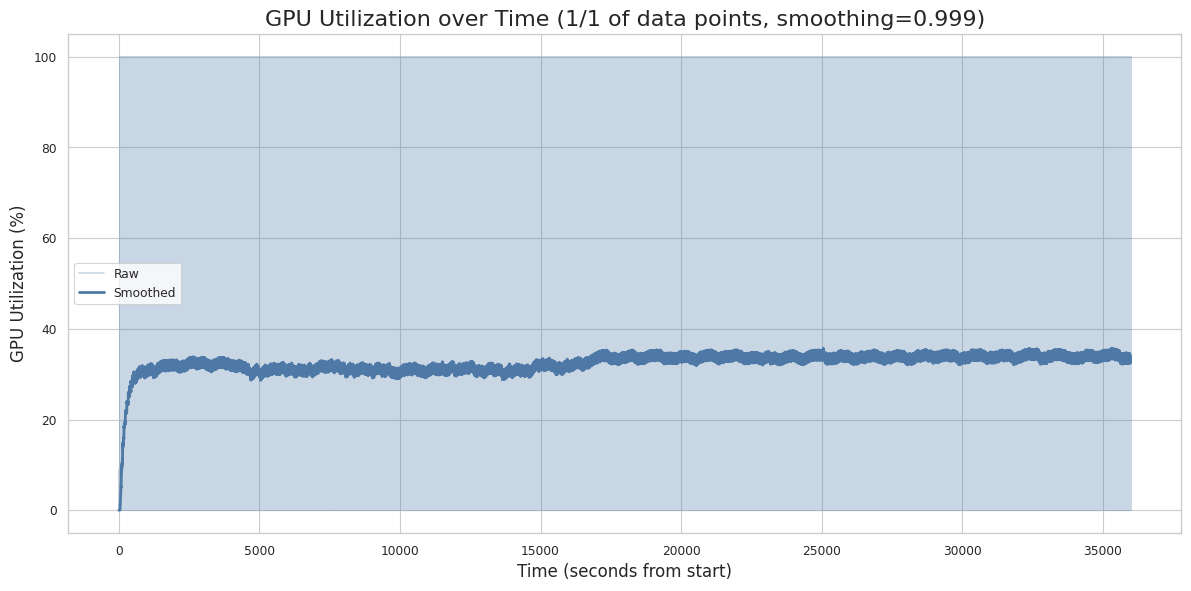

In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def wandb_smooth(array, weight=0.6):
    last = array[0]
    smoothed = np.zeros(len(array))
    for i, point in enumerate(array):
        smoothed_val = last * weight + (1 - weight) * point
        smoothed[i] = smoothed_val
        last = smoothed_val
    return smoothed

def plot_smoothed(csv_path, downsample_factor=1, smoothing_weight=0.6):
    # load the data
    df = pd.read_csv(csv_path)
    
    # convert timestamp to datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
    
    # normalize time to start at 0
    start_time = df['timestamp'].min()
    df['normalized_time'] = (df['timestamp'] - start_time).dt.total_seconds()
    
    # downsample
    df_downsampled = df.iloc[::downsample_factor]
    
    # apply smoothing
    df_downsampled['gpu_util_smooth'] = wandb_smooth(df_downsampled['gpu_util'], smoothing_weight)
    
    # set the style
    sns.set_style("whitegrid")
    sns.set_context("paper")
    
    # create the plot
    plt.figure(figsize=(12, 6))
    sns.lineplot(x='normalized_time', y='gpu_util', data=df_downsampled, 
                 color='#4e79a7', alpha=0.3, label='Raw')
    sns.lineplot(x='normalized_time', y='gpu_util_smooth', data=df_downsampled, 
                 color='#4e79a7', linewidth=2, label='Smoothed')
    
    # customize
    plt.title(f'GPU Utilization over Time (1/{downsample_factor} of data points, smoothing={smoothing_weight})', 
              fontsize=16)
    plt.xlabel('Time (seconds from start)', fontsize=12)
    plt.ylabel('GPU Utilization (%)', fontsize=12)
    plt.legend()
    
    # add a bit of padding
    plt.tight_layout()
    
    # show the plot
    plt.show()

# usage
plot_smoothed("baseline-2024-06-26_15-14/gpu.csv", downsample_factor=1, smoothing_weight=0.999)

/tmp/ipykernel_13942/2946648273.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_minute['seconds'] = (df_minute['timestamp'] - start_time).dt.total_seconds()
/tmp/ipykernel_13942/2946648273.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_minute['gpu_util_smooth'] = wandb_smooth(df_minute['gpu_util'], smoothing_weight)


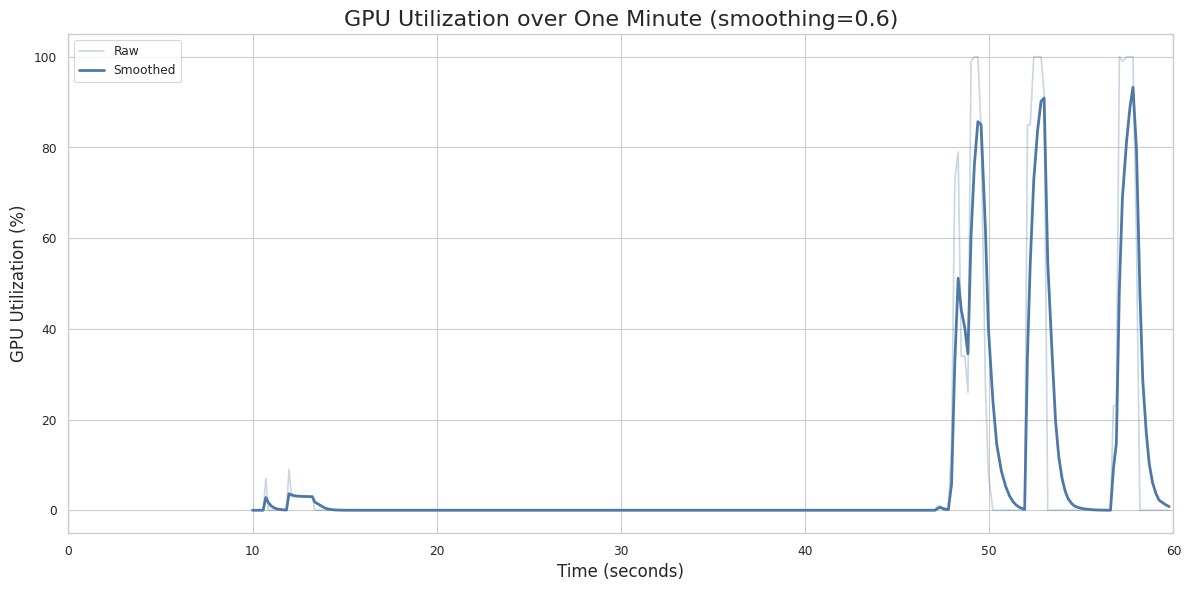

In [35]:
def plot_one_minute(csv_path, output_path, start_offset_seconds=0, smoothing_weight=0.6):
    # load the data
    df = pd.read_csv(csv_path)
    
    # convert timestamp to datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
    
    # normalize time to start at 0
    start_time = df['timestamp'].min() + timedelta(seconds=start_offset_seconds)
    end_time = start_time + timedelta(seconds=60)
    
    # filter to one minute of data
    df_minute = df[(df['timestamp'] >= start_time) & (df['timestamp'] < end_time)]
    
    # calculate seconds from start of the minute
    df_minute['seconds'] = (df_minute['timestamp'] - start_time).dt.total_seconds()
    
    # apply smoothing
    df_minute['gpu_util_smooth'] = wandb_smooth(df_minute['gpu_util'], smoothing_weight)
    
    # set the style
    sns.set_style("whitegrid")
    sns.set_context("paper")
    
    # create the plot
    plt.figure(figsize=(12, 6))
    sns.lineplot(x='seconds', y='gpu_util', data=df_minute, 
                 color='#4e79a7', alpha=0.3, label='Raw')
    sns.lineplot(x='seconds', y='gpu_util_smooth', data=df_minute, 
                 color='#4e79a7', linewidth=2, label='Smoothed')
    
    # customize
    plt.title(f'GPU Utilization over One Minute (smoothing={smoothing_weight})', fontsize=16)
    plt.xlabel('Time (seconds)', fontsize=12)
    plt.ylabel('GPU Utilization (%)', fontsize=12)
    plt.xlim(0, 60)
    plt.legend()
    
    # add a bit of padding
    plt.tight_layout()
    plt.show()
    # save as svg
    plt.savefig(output_path, format='svg')
    plt.close()  # close the plot to free up memory

# usage
plot_one_minute("baseline-2024-06-26_15-14/gpu.csv", 'gpu_utilization_minute.svg', start_offset_seconds=-10, smoothing_weight=0.6)

In [49]:
def wandb_smooth(array, weight=0.6):
    last = array[0]
    smoothed = np.zeros(len(array))
    for i, point in enumerate(array):
        smoothed_val = last * weight + (1 - weight) * point
        smoothed[i] = smoothed_val
        last = smoothed_val
    return smoothed

def plot_one_minute(csv_path, output_path, shift_time=0, polling_rate=10, smoothing_weight=0.6):
    # load the data
    df = pd.read_csv(csv_path)
    
    # convert timestamp to datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
    
    # calculate start and end indices
    start_index = shift_time * polling_rate
    end_index = start_index + (60 * polling_rate)  # 60 seconds * polling rate
    
    # subsample the data
    df_minute = df.iloc[start_index:end_index].copy()
    
    # reset index to start from 0
    df_minute = df_minute.reset_index(drop=True)
    
    # calculate seconds from start of the minute
    df_minute['seconds'] = df_minute.index / polling_rate
    
    # apply smoothing
    df_minute['gpu_util_smooth'] = wandb_smooth(df_minute['gpu_util'], smoothing_weight)
    
    # set the style
    sns.set_style("whitegrid")
    sns.set_context("paper")
    
    # create the plot
    plt.figure(figsize=(12, 6))
    sns.lineplot(x='seconds', y='gpu_util', data=df_minute, 
                 color='#4e79a7', alpha=0.3, label='Raw')
    sns.lineplot(x='seconds', y='gpu_util_smooth', data=df_minute, 
                 color='#4e79a7', linewidth=2, label='Smoothed')
    
    # customize
    plt.title(f'GPU Utilization over One Minute (smoothing={smoothing_weight})', fontsize=16)
    plt.xlabel('Time (seconds)', fontsize=12)
    plt.ylabel('GPU Utilization (%)', fontsize=12)
    plt.xlim(0, 60)
    plt.legend()
    
    # add a bit of padding
    plt.tight_layout()
    
    # save as svg
    plt.savefig(output_path, format='svg')
    plt.close()  # close the plot to free up memory

# usage
plot_one_minute("baseline-2024-06-26_15-14/gpu.csv", 'gpu_utilization_minute.svg', shift_time=100, polling_rate=10, smoothing_weight=0.6)

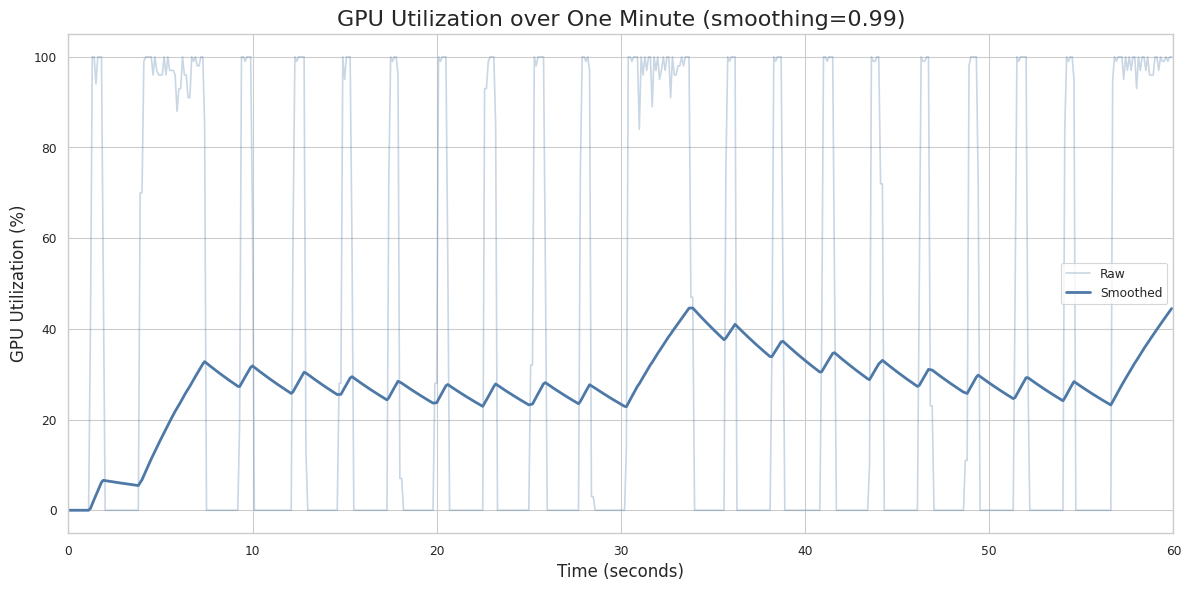

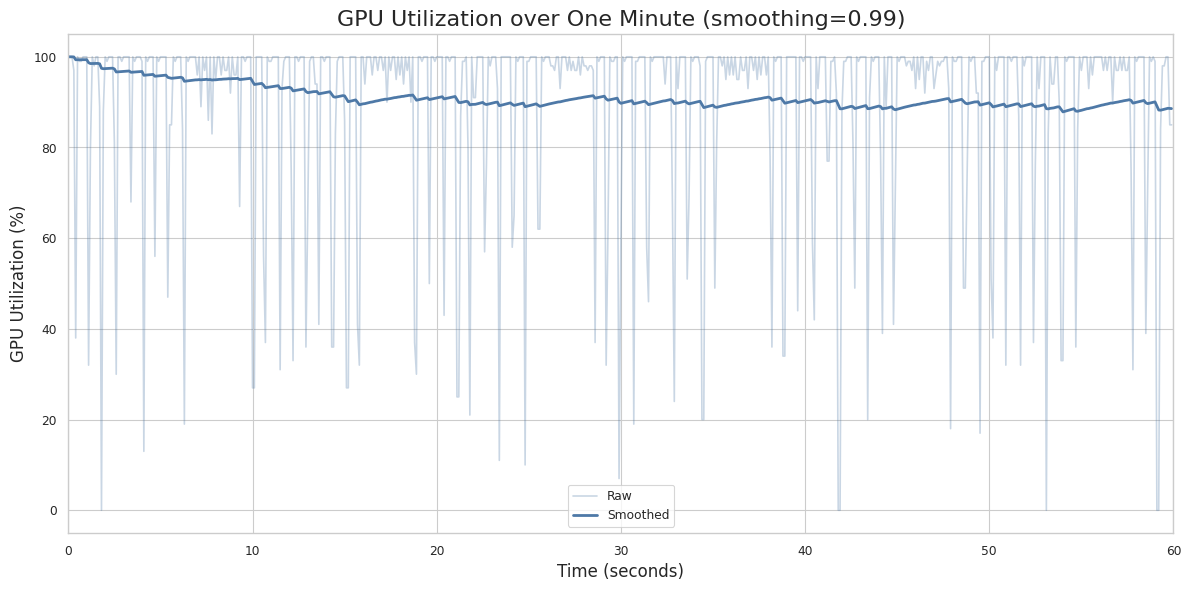

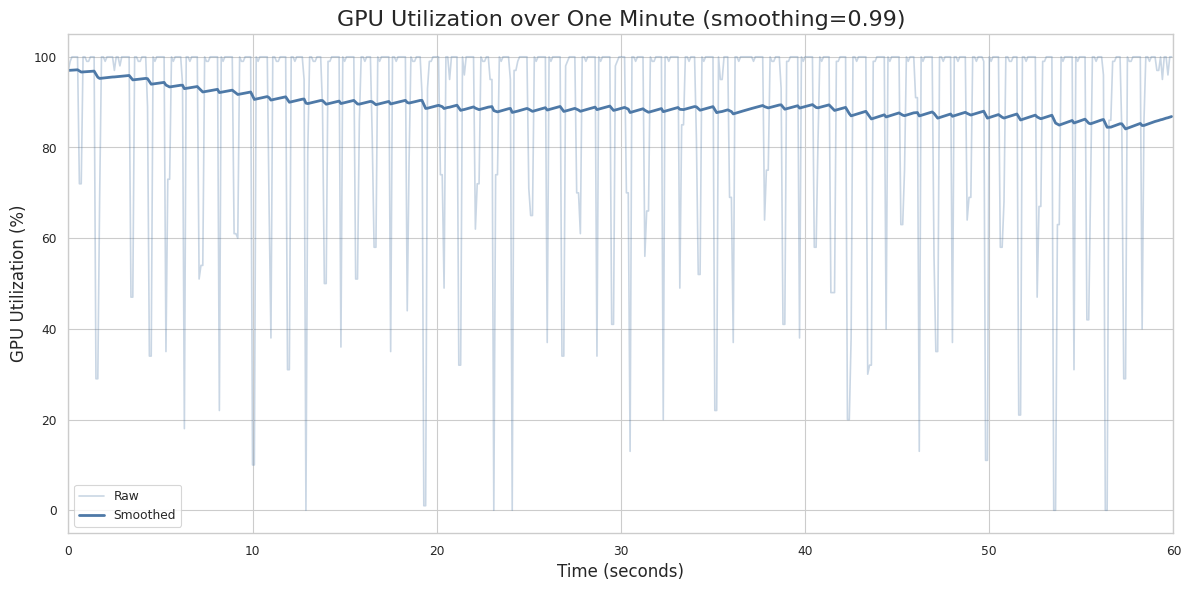

In [45]:
smoothing = 0.99
shift = 1000

svg_path = "./svg/"
svg_path_baseline = svg_path + "gpu_util_minute_baseline.svg"
svg_path_wirehead_local =  svg_path + "gpu_util_minute_wirehead_local.svg"
svg_path_wirehead_distributed = svg_path + "gpu_util_minute_wirehead.svg"

plot_one_minute("baseline-2024-06-26_15-14/gpu.csv", svg_path_baseline, shift_time=shift, polling_rate=10, smoothing_weight=smoothing)
plot_one_minute("wirehead_train-2024-06-25_20-07/gpu.csv", svg_path_wirehead_local, shift_time=shift, polling_rate=10, smoothing_weight=smoothing)
plot_one_minute("multigpu_gen-2024-06-27_01-37/gpu.csv", svg_path_wirehead_distributed, shift_time=shift, polling_rate=10, smoothing_weight=smoothing)


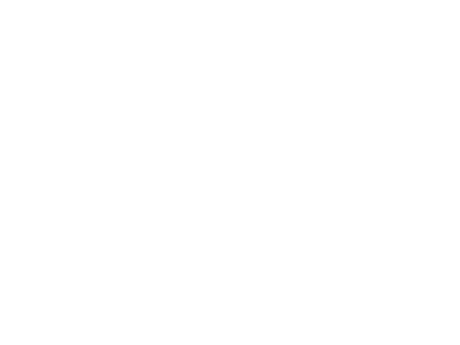

In [48]:
from IPython.display import SVG, display
# display the svg
display(SVG(svg_path_wirehead_distributed))

In [ ]:

    plt.show()
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import SVG, display

def plot_one_minute(csv_path, output_path, shift_time=0, polling_rate=10, smoothing_weight=0.6):
    # load and process data
    df = pd.read_csv(csv_path)
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
    start_index = shift_time * polling_rate
    end_index = start_index + (60 * polling_rate)
    df_minute = df.iloc[start_index:end_index].copy().reset_index(drop=True)
    df_minute['seconds'] = df_minute.index / polling_rate
    df_minute['gpu_util_smooth'] = wandb_smooth(df_minute['gpu_util'], smoothing_weight)
    
    # create the plot
    plt.figure(figsize=(12, 6))
    sns.lineplot(x='seconds', y='gpu_util', data=df_minute, 
                 color='#4e79a7', alpha=0.3, label='Raw')
    sns.lineplot(x='seconds', y='gpu_util_smooth', data=df_minute, 
                 color='#4e79a7', linewidth=2, label='Smoothed')
    
    # customize
    plt.title(f'GPU Utilization over One Minute (smoothing={smoothing_weight})', fontsize=16)
    plt.xlabel('Time (seconds)', fontsize=12)
    plt.ylabel('GPU Utilization (%)', fontsize=12)
    plt.xlim(0, 60)
    plt.legend()
    plt.tight_layout()
    
    # save to file
    plt.savefig(output_path, format='svg')
    plt.close()

# usage
output_file = 'gpu_utilization_minute.svg'
plot_one_minute('cropped_gpu.csv', output_file, shift_time=0, polling_rate=10, smoothing_weight=0.6)

# display in notebook
display(SVG(output_file))